In [34]:
import numpy as np


class InputSet:
    def __init__(self, height, width, ):
        self.event_bitrate = None
        self.adder_features = np.zeros((height, width), dtype=bool)
        self.adder_time = None
        self.cv_features = np.zeros((height, width), dtype=bool)
        self.cv_time = None
        self.psnr = None
        self.mse = None
        self.ssim = None

    def total_adder(self):
        return np.sum(self.adder_features.astype(int))

    def total_cv(self):
        return np.sum(self.cv_features.astype(int))

In [35]:
def process_entry(entry, input_sets):
    if 's' in entry:
        if "OpenCV" in entry['s']:
            input_sets[-1].cv_features[entry['y'], entry['x']] = True
        elif "ADDER" in entry['s']:
            input_sets[-1].adder_features[entry['y'], entry['x']] = True
        else:
            raise Exception("Malformed entry")
    elif 'psnr' in entry:
        input_sets[-1].psnr = entry['psnr']
        input_sets[-1].mse = entry['mse']
        input_sets[-1].ssim = entry['ssim']


In [36]:
import pickle

objects = []
with (open("/home/andrew/Code/adder-codec-rs/features_19_10_2023_16_13_39.log", "rb")) as openfile:
    # Read the dimensions
    dims = openfile.readline().decode('UTF-8')
    print(dims)
    width = int(dims.split('x')[0])
    height = int(dims.split('x')[1])
    #
    dbg_lines = 0
    #
    input_interval_idx = 0
    #
    input_sets = [InputSet(height, width)]

    while True:
        try:
            entry = pickle.load(openfile)
            if type(entry) == str and "ADDER FAST:" in entry:
                # The start of a new interval
                time = entry.split(': ')[1]
                input_sets[-1].adder_time = int(time)
                continue
            elif type(entry) == str and "bps:" in entry:
                # The bitrate
                # The end of the interval
                bitrate = entry.split(': ')[1]
                input_sets[-1].event_bitrate = bitrate

                input_sets += [InputSet(height, width)]
                input_interval_idx += 1
                continue
            elif type(entry) == str and "OpenCV FAST:" in entry:
                time = entry.split(': ')[1]
                input_sets[-1].cv_time = int(time)

            elif type(entry) == str and "META:" in entry:
                print(entry)
            else:
                process_entry(entry, input_sets)

                # print(entry)
                dbg_lines += 1
                # if dbg_lines == 100000:
                #     break
        except pickle.UnpicklingError:
            print(openfile.readline().decode('UTF-8'))
        except EOFError:
            break



320x180x1

META: Ticks per second: 6120

META: Reference ticks per source interval: 255

META: Δt_max: 76500

META: CRF: 5

META: c_thresh_baseline: 3

META: c_thresh_max: 10

META: c_increase_velocity: 5


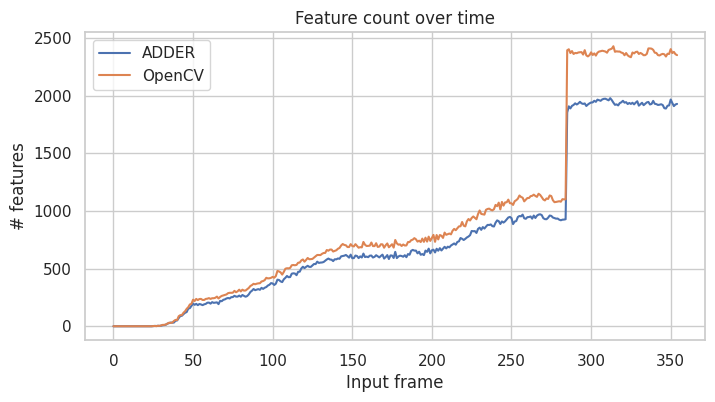

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import mpld3

adder_feature_count = [obj.total_adder() for obj in input_sets]
cv_feature_count = [obj.total_cv() for obj in input_sets]

sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))

sns.lineplot(x=range(len(input_sets) - 1), y=adder_feature_count[:-1], marker=None, label="ADDER")
sns.lineplot(x=range(len(input_sets) - 1), y=cv_feature_count[:-1], marker=None, label="OpenCV")
plt.ylabel("# features")
plt.xlabel("Input frame")
plt.title("Feature count over time")

plt.show()
# interactive_plot = mpld3.display()
# interactive_plot

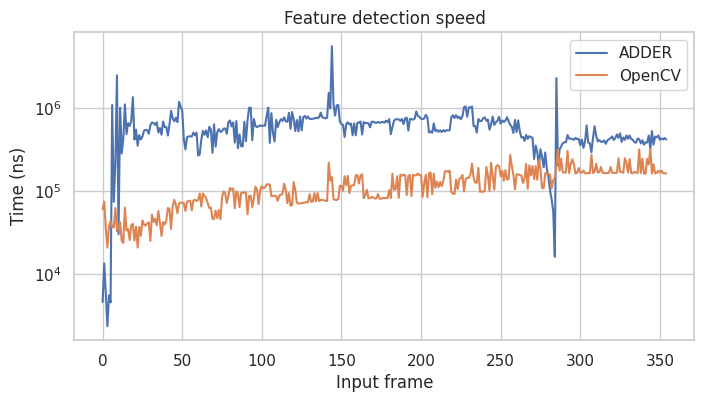

OpenCV mean: 120817.60845070423   Median: 108740.0
ADDER mean: 604468.6084507043 (400.3%)   Median: 574003.0


In [38]:
adder_times = [obj.adder_time for obj in input_sets]
cv_times = [obj.cv_time for obj in input_sets]

sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))

sns.lineplot(x=range(len(input_sets)), y=adder_times, marker=None, label="ADDER")
sns.lineplot(x=range(len(input_sets)), y=cv_times, marker=None, label="OpenCV")
plt.ylabel("Time (ns)")
plt.xlabel("Input frame")
plt.yscale('log')
plt.title("Feature detection speed")

plt.show()
# interactive_plot = mpld3.display()
# interactive_plot


cv_mean = np.mean(np.array(cv_times[:-1]))
adder_mean = np.mean(np.array(adder_times[:-1]))
percent_change = (adder_mean / cv_mean) - 1
print('OpenCV mean:', cv_mean, '  Median:', np.median(np.array(cv_times[:-1])))
print('ADDER mean:', adder_mean, "({:.1f}%)".format(percent_change * 100), '  Median:',
      np.median(np.array(adder_times[:-1])))


# Bitrate over time

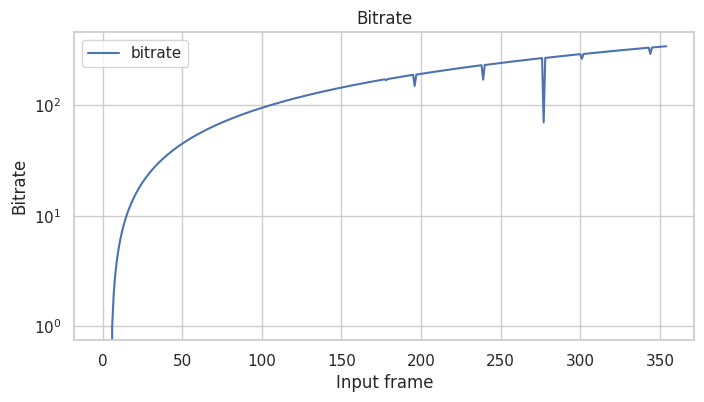

['0', '0', '0', '0', '0', '0', '93144384', '2277504', '2961792', '95387328', '910656', '71362944', '27599616', '49273920', '67512960', '35026560', '48781440', '47487168', '51698304', '47333376', '43946496', '50205312', '45187200', '50680512', '46084032', '46825344', '46491840', '62114688', '46052928', '51929856', '40799808', '51843456', '45470592', '52475904', '47782656', '46851264', '49816512', '46210176', '53039232', '51262848', '53645760', '50765184', '53849664', '50184576', '54749952', '50827392', '54701568', '50640768', '55194048', '51043392', '55233792', '7110720', '7286976', '7592832', '7756992', '8119872', '8430912', '8560512', '8938944', '8904384', '9386496', '9127296', '9739008', '10376640', '10426752', '10991808', '11297664', '10919232', '11117952', '11301120', '11577600', '11530944', '11956032', '12873600', '12787200', '12726720', '12942720', '13478400', '13646016', '14442624', '14247360', '14646528', '14772672', '14905728', '15152832', '15494976', '15434496', '15615936', '

In [45]:
bitrates = [obj.event_bitrate for obj in input_sets[:-1]]

sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))

sns.lineplot(x=range(len(input_sets) - 1), y=bitrates, marker=None, label="bitrate")
plt.ylabel("Bitrate")
plt.xlabel("Input frame")
plt.yscale('log')
plt.gca().invert_yaxis()
plt.title("Bitrate")

plt.show()
print(bitrates)
# interactive_plot = mpld3.display()
# interactive_plot


# cv_mean = np.mean(np.array(cv_times[:-1]))
# adder_mean = np.mean(np.array(adder_times[:-1]))
# percent_change = (adder_mean / cv_mean) - 1
# print('OpenCV mean:', cv_mean, '  Median:', np.median(np.array(cv_times[:-1])))
# print('ADDER mean:', adder_mean, "({:.1f}%)".format(percent_change * 100), '  Median:',
#       np.median(np.array(adder_times[:-1])))
